# Analysis

Take the best mock build in `main.ipynb` and run some analysis on it.

## Imports etc

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [2]:
data = np.load("mock.npy")

# Satellite fraction at given SM

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


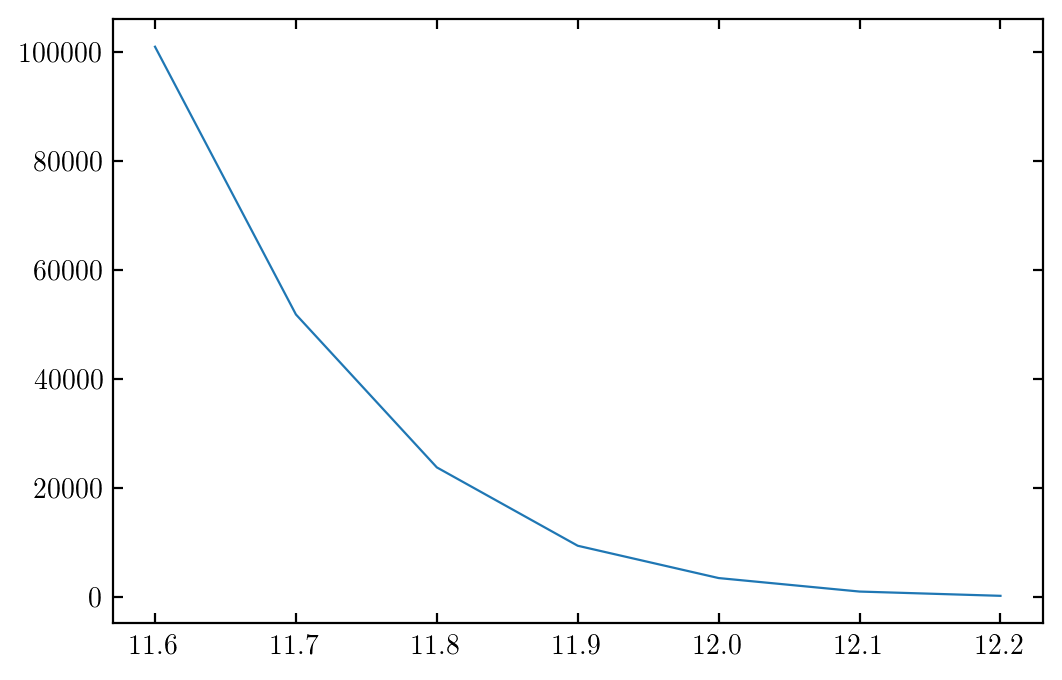

In [10]:
bins = np.linspace(11.5, 12.2, num=8)
bin_centers = bins[:-1] + np.diff(bins)[0]

counts, _, _ = scipy.stats.binned_statistic(data["stellar_mass"], None, statistic="count", bins=10**bins)

_, ax = plt.subplots()
ax.plot(bin_centers, counts)